In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
font = {'family' : 'Times New Roman',
        'size'   : 10}
plt.rc('font', **font)

In [66]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_public')
materialization = 1300
client.version = materialization
tables1300 = client.materialize.get_tables()

### Layer 4 and layer 2/3, excitatory and inhibitory

In [26]:
celltypes_df = client.materialize.tables.baylor_gnn_cell_type_fine_model_v2().query()
celltypes_df

,id_ref,created_ref,valid_ref,target_id,classification_system,cell_type,id,created,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,4490,2022-12-16 22:26:46.784878+00:00,t,18023,baylor_gnn_cell_type_fine,NGC,18023,2020-09-28 22:43:00.306675+00:00,t,264.791327,75934266147628505,864691135207734905,"[81008, 108240, 16995]","[nan, nan, nan]","[nan, nan, nan]"
1,28785,2022-12-16 22:28:23.869072+00:00,t,18312,baylor_gnn_cell_type_fine,NGC,18312,2020-09-28 22:44:09.407821+00:00,t,221.584753,75441272688753483,864691135758479438,"[77392, 105280, 17650]","[nan, nan, nan]","[nan, nan, nan]"
2,2439,2022-12-16 22:26:45.373463+00:00,t,255686,baylor_gnn_cell_type_fine,23P,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
3,26721,2022-12-16 22:28:06.825046+00:00,t,747145,baylor_gnn_cell_type_fine,NGC,747145,2020-09-28 22:45:19.522358+00:00,t,373.959066,119071819432080950,864691136010301614,"[394912, 119904, 26804]","[nan, nan, nan]","[nan, nan, nan]"
4,31608,2022-12-16 22:28:25.882301+00:00,t,204945,baylor_gnn_cell_type_fine,6P-CT,204945,2020-09-28 22:44:25.115874+00:00,t,250.471875,84466820245155764,864691135208560505,"[142992, 241984, 19204]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49046,11733,2022-12-16 22:27:24.650172+00:00,t,408238,baylor_gnn_cell_type_fine,6P-CT,408238,2020-09-28 22:44:26.690713+00:00,t,252.318351,97205212745817217,864691135685648823,"[235840, 254384, 23481]","[nan, nan, nan]","[nan, nan, nan]"
49047,6270,2022-12-16 22:27:01.478212+00:00,t,309459,baylor_gnn_cell_type_fine,6P-IT,309459,2020-09-28 22:44:13.250713+00:00,t,229.114511,89745782466493531,864691135684809458,"[181680, 251872, 24620]","[nan, nan, nan]","[nan, nan, nan]"
49048,37193,2022-12-16 22:28:45.520696+00:00,t,303035,baylor_gnn_cell_type_fine,5P-IT,303035,2020-09-28 22:43:28.265348+00:00,t,497.987748,89738016763137206,864691135617649257,"[181632, 193824, 21686]","[nan, nan, nan]","[nan, nan, nan]"
49049,31582,2022-12-16 22:28:25.863930+00:00,t,262770,baylor_gnn_cell_type_fine,4P,262770,2020-09-28 22:44:38.600842+00:00,t,270.246216,87764805641077672,864691135996353194,"[167408, 172304, 21209]","[nan, nan, nan]","[nan, nan, nan]"


In [28]:
celltypes_df["cell_type"].value_counts()

cell_type
23P      18689
5P-IT     7433
4P        7391
6P-CT     4972
6P-IT     4943
BC        1424
5P-PT     1219
MC         984
BPC        946
NGC        536
5P-NP      514
Name: count, dtype: int64

The classes correspond to the ones in 'allen_v1_column_types_slanted_ref'. 23P and 4P are excitatory cells from layers 2/3 and 4 respectively. To get the inhibitory cells according to the diagram, I extract all inhibitory cells that project onto layer 2/3 among the inhibitory classes BC, BPC and MC. *(What are 5P-PT and NGC? Are they inhibitory?)*. 

In [31]:
layer4_exc_ids = list(client.materialize.query_table("baylor_gnn_cell_type_fine_model_v2", filter_in_dict={"cell_type" : ["4P"]}).pt_root_id)
layer23_exc_ids = list(client.materialize.query_table("baylor_gnn_cell_type_fine_model_v2", filter_in_dict={"cell_type" : ["23P"]}).pt_root_id)

In [82]:
len(layer4_exc_ids), len(layer23_exc_ids)

(7391, 18689)

In [40]:
# Root ids for inhibitory classes

inh_ids = list(client.materialize.query_table("baylor_gnn_cell_type_fine_model_v2", filter_in_dict={"cell_type" : ["BC", "BPC", "MC"]}).pt_root_id)

In [81]:
len(inh_ids)

3354

In [78]:
# Inhibitory cells that project onto layer 2/3

client.materialize.synapse_query(pre_ids=inh_ids, post_ids=layer23_exc_ids)

KeyboardInterrupt: 

### Proofreading status

In [101]:
proof_all_df = client.materialize.query_table("proofreading_status_and_strategy")
proof_all_df

,id,created,superceded_id,valid,valid_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_supervoxel_id,pt_root_id,pt_position
0,1,2024-06-03 19:45:52.501252+00:00,NaN,t,864691135441799752,t,t,dendrite_extended,axon_interareal,91346396048860133,864691135441799752,"[193152, 118976, 21021]"
1,3,2024-06-03 19:45:52.503198+00:00,NaN,t,864691135855890478,t,t,dendrite_extended,axon_interareal,84591134382832426,864691135855890478,"[144072, 119965, 24049]"
2,4,2024-06-03 19:45:52.504040+00:00,NaN,t,864691136521831825,t,t,dendrite_extended,axon_interareal,109368765749515987,864691136521831825,"[324588, 177956, 19221]"
3,5,2024-06-03 19:45:52.504877+00:00,NaN,t,864691135952122147,t,t,dendrite_extended,axon_interareal,112175063088115757,864691135952122147,"[344768, 115350, 19786]"
4,7,2024-06-03 19:45:52.506448+00:00,NaN,t,864691135163673901,t,t,dendrite_extended,axon_fully_extended,89737260647882239,864691135163673901,"[181552, 188512, 20422]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1860,3062,2025-01-12 03:00:00.936352+00:00,NaN,t,864691135867413893,t,t,dendrite_clean,axon_partially_extended,89031992993240476,864691135867413893,"[176480, 176416, 22599]"
1861,3063,2025-01-12 03:00:00.954516+00:00,NaN,t,864691135276601317,t,t,dendrite_clean,axon_partially_extended,88326724936602021,864691135276601317,"[171200, 164992, 22279]"
1862,3064,2025-01-12 03:00:00.972946+00:00,NaN,t,864691135742247787,t,t,dendrite_clean,axon_partially_extended,90297324450184090,864691135742247787,"[185600, 166752, 20750]"
1863,3065,2025-01-12 03:00:00.992770+00:00,NaN,t,864691135591960075,t,t,dendrite_extended,axon_fully_extended,88473509805848805,864691135591960075,"[172368, 209936, 22622]"


In preprint: axons -> extended, dendrites-> clean

In [43]:
proof_all_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1459
none                        149
axon_interareal             130
axon_fully_extended         127
Name: count, dtype: int64

In [46]:
proof_all_df["strategy_dendrite"].value_counts()

strategy_dendrite
dendrite_extended    1273
dendrite_clean        580
none                   12
Name: count, dtype: int64

In [52]:
# Filtering to at least extended axons and at least clean dendrites
# NOTE: Does axon_interareal count as extended?

proofread_ids = list(client.materialize.query_table("proofreading_status_and_strategy", filter_in_dict={"strategy_axon" : ["axon_partially_extended", "axon_fully_extended", "axon_interareal"], "strategy_dendrite" : ["dendrite_extended", "dendrite_clean"]}).pt_root_id)

In [55]:
len(proofread_ids)

1704

In [80]:
# By using the boolean in the table

proofread_boolean_ids = list(client.materialize.query_table("proofreading_status_and_strategy", filter_in_dict={"status_dendrite" : ["t"], "status_axon" : ["t"]}).pt_root_id)
len(proofread_boolean_ids)

1711

### Preferred orientation

In [56]:
client.materialize.query_table("functional_properties_v3_bcm")

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,...,scan_idx,unit_id,pref_ori,pref_dir,gOSI,gDSI,cc_abs,pt_position,bb_start_position,bb_end_position
0,335649,2020-09-28 22:41:20.303372+00:00,t,295.861125,93747454767483710,864691135702330235,7293,2024-01-22 08:09:51.497934+00:00,t,335649,...,2,6883,1.648632,1.648632,0.063371,0.047185,0.445869,"[210784, 182032, 22673]","[nan, nan, nan]","[nan, nan, nan]"
1,293318,2020-09-28 22:45:23.572432+00:00,t,430.108180,90783515419343652,864691135430194992,414,2024-01-22 08:09:51.497934+00:00,t,293318,...,4,8066,1.407509,4.549102,0.090610,0.101717,0.296396,"[189472, 119296, 26037]","[nan, nan, nan]","[nan, nan, nan]"
2,332833,2020-09-28 22:44:41.864456+00:00,t,274.418729,93535317407139914,864691135387371905,6950,2024-01-22 08:09:51.497934+00:00,t,332833,...,7,6413,0.034229,3.175822,0.345478,0.225768,0.372098,"[209328, 174304, 20004]","[nan, nan, nan]","[nan, nan, nan]"
3,295460,2020-09-28 22:41:24.368712+00:00,t,208.616653,90225718084406516,864691135661410544,10081,2024-01-22 08:09:51.497934+00:00,t,295460,...,3,7748,1.586712,1.586712,0.208914,0.035112,0.446928,"[185088, 157776, 15691]","[nan, nan, nan]","[nan, nan, nan]"
4,585835,2020-09-28 22:41:12.649674+00:00,t,325.562860,111336342008911475,864691135349275351,11085,2024-01-22 08:09:51.497934+00:00,t,585835,...,5,7441,1.598579,4.740172,0.146034,0.071207,-0.011697,"[338864, 157856, 20916]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,299152,2020-09-28 22:44:34.787046+00:00,t,264.902410,90227918047331899,864691136363154402,1868,2024-01-22 08:09:51.497934+00:00,t,299152,...,6,6654,0.022189,3.163782,0.414591,0.196683,0.792351,"[185168, 174208, 22967]","[nan, nan, nan]","[nan, nan, nan]"
12090,262655,2020-09-28 22:45:05.760338+00:00,t,318.102897,88256012393674444,864691135339530726,3763,2024-01-22 08:09:51.497934+00:00,t,262655,...,3,7841,2.687019,5.828612,0.388338,0.075173,0.629100,"[170784, 162192, 20696]","[nan, nan, nan]","[nan, nan, nan]"
12091,224188,2020-09-28 22:44:06.796036+00:00,t,217.948815,86915776304724899,864691134949221372,2940,2024-01-22 08:09:51.497934+00:00,t,224188,...,5,2091,1.184429,4.326022,0.192705,0.029364,0.746748,"[161168, 138304, 19698]","[nan, nan, nan]","[nan, nan, nan]"
12092,260548,2020-09-28 22:44:59.140141+00:00,t,303.923036,89169225520073388,864691136725032701,4075,2024-01-22 08:09:51.497934+00:00,t,260548,...,2,4586,2.733149,5.874742,0.450605,0.286260,0.313106,"[177360, 150528, 20753]","[nan, nan, nan]","[nan, nan, nan]"


In [57]:
orientations = list(client.materialize.query_table("functional_properties_v3_bcm").pref_ori)

Text(0.5, 0, 'Preferred orientation in radians')

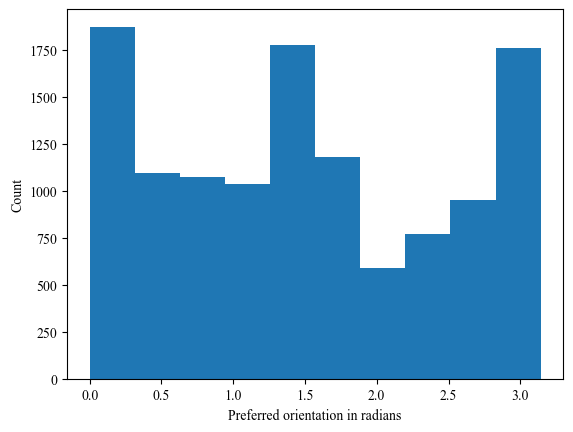

In [68]:
plt.hist(orientations)
plt.ylabel("Count")
plt.xlabel("Preferred orientation in radians")

### Area

In [70]:
areas_df = client.materialize.query_table("nucleus_functional_area_assignment")
areas_df

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,tag,valid,target_id,value,pt_position,bb_start_position,bb_end_position
0,996,2020-09-28 22:40:49.459189+00:00,t,35.147776,0,0,1,2024-05-24 03:41:13.434068+00:00,V1,t,996,832.103645,"[60464, 93616, 20968]","[nan, nan, nan]","[nan, nan, nan]"
1,1833,2020-09-28 22:42:05.748213+00:00,t,35.934044,0,0,2,2024-05-24 03:41:13.434663+00:00,V1,t,1833,859.819586,"[56800, 97280, 19929]","[nan, nan, nan]","[nan, nan, nan]"
2,1841,2020-09-28 22:44:35.992946+00:00,t,265.585951,0,0,3,2024-05-24 03:41:13.435193+00:00,V1,t,1841,860.626673,"[57536, 105584, 19883]","[nan, nan, nan]","[nan, nan, nan]"
3,1896,2020-09-28 22:43:54.059800+00:00,t,174.558413,0,0,4,2024-05-24 03:41:13.435742+00:00,V1,t,1896,848.191685,"[59872, 96608, 19853]","[nan, nan, nan]","[nan, nan, nan]"
4,1998,2020-09-28 22:43:41.083981+00:00,t,137.669345,72978435697419638,864691136050815731,5,2024-05-24 03:41:13.436283+00:00,V1,t,1998,848.382777,"[59936, 105872, 20078]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144115,809403,2020-09-28 22:41:38.665091+00:00,t,31.710577,0,0,144116,2024-05-24 03:50:24.271900+00:00,AL,t,809403,115.064915,"[415680, 278736, 24814]","[nan, nan, nan]","[nan, nan, nan]"
144116,809411,2020-09-28 22:42:09.271838+00:00,t,38.341673,0,0,144117,2024-05-24 03:50:24.272390+00:00,AL,t,809411,118.736822,"[416032, 278080, 24725]","[nan, nan, nan]","[nan, nan, nan]"
144117,809425,2020-09-28 22:41:57.521312+00:00,t,27.955200,0,0,144118,2024-05-24 03:50:24.272869+00:00,AL,t,809425,144.683319,"[415984, 277664, 24076]","[nan, nan, nan]","[nan, nan, nan]"
144118,809434,2020-09-28 22:43:56.464677+00:00,t,187.086602,0,0,144119,2024-05-24 03:50:24.273354+00:00,AL,t,809434,140.412545,"[416560, 287152, 24180]","[nan, nan, nan]","[nan, nan, nan]"


In [74]:
areas_df["tag"].value_counts()

tag
V1    90765
RL    31622
AL    20859
LM      874
Name: count, dtype: int64

### Connectivity matrix

In [ ]:
# proofread_boolean_ids: all proofread cells
# layer4_exc_ids: layer 4 excitatory cells
# layer23_exc_ids: layer 2/3 excitatory cells
# inh_ids: all inhibitory cells

In [116]:
# Restrict cells in layers 4 and 2/3 to proofread cells (at least there's less of them this way)

l4e_proofread_ids = list(set(proofread_boolean_ids) & set(layer4_exc_ids))
l23e_proofread_ids = list(set(proofread_boolean_ids) & set(layer23_exc_ids))
inh_proofread_ids = list(set(proofread_boolean_ids) & set(inh_ids))

In [117]:
# Find (proofread) inhibitory cells that project to layer 2/3

inh23_proofread_ids = list(set(list(client.materialize.synapse_query(pre_ids=inh_proofread_ids, post_ids=l23e_proofread_ids).pre_pt_root_id)))

In [118]:
len(inh23_proofread_ids), len(inh_proofread_ids) # Of the 78 proofread inhibitory neurons, 53 were projecting onto layer 2/3

(53, 78)

In [119]:
len(l4e_proofread_ids), len(l23e_proofread_ids), len(inh23_proofread_ids) # Final counts of the cells included in this section

(369, 535, 53)

In [124]:
# Connectivity matrix

all_cells = l4e_proofread_ids + l23e_proofread_ids + inh23_proofread_ids # List of all cells

synapses_df = client.materialize.synapse_query(pre_ids=all_cells, post_ids=all_cells)


In [127]:
synapses_df

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,148367619,2020-11-04 11:46:41.982682+00:00,NaN,t,4880,88187223727657156,864691136057875416,88187223727666196,864691135659200386,"[170264, 174184, 17059]","[170378, 174182, 17060]","[170300, 174144, 17052]"
2,144648847,2020-11-04 10:25:21.607615+00:00,NaN,t,5720,87827409285525264,864691136389688695,87827409285520659,864691136143786292,"[167926, 114800, 22586]","[167920, 114768, 22583]","[167926, 114776, 22585]"
5,130534906,2020-11-04 12:40:44.343714+00:00,NaN,t,1548,86983808855300937,864691136005322698,86983808855297157,864691135726971967,"[161792, 120902, 21938]","[161780, 120956, 21939]","[161844, 120926, 21939]"
6,157729830,2020-11-04 06:48:59.510128+00:00,NaN,t,1032,88960661975421542,864691135976063855,88960661975426116,864691135430268976,"[175928, 169348, 21412]","[175850, 169340, 21414]","[175862, 169320, 21413]"
7,148779778,2020-11-04 12:00:21.388958+00:00,NaN,t,3000,88262128292962327,864691135561597409,88262128292973224,864691136057875416,"[170654, 207822, 19785]","[170676, 207822, 19790]","[170690, 207804, 19789]"
...,...,...,...,...,...,...,...,...,...,...,...,...
35996,152982854,2020-11-04 12:56:45.857005+00:00,NaN,t,4052,88819306078601292,864691134941412707,88819306078589783,864691135857723438,"[174900, 164858, 21650]","[174798, 164880, 21642]","[174860, 164860, 21644]"
35997,161294241,2020-11-04 14:03:17.308897+00:00,NaN,t,1952,89171287372704179,864691136090688823,89171287372707508,864691135857723438,"[177486, 165938, 22703]","[177526, 165846, 22705]","[177540, 165862, 22703]"
35998,143203889,2020-11-04 13:38:35.621556+00:00,NaN,t,480,88042707339085917,864691135772774651,88042638619610573,864691135857723438,"[169432, 145620, 22140]","[169362, 145566, 22135]","[169416, 145544, 22137]"
36000,189133117,2020-11-04 08:11:04.727253+00:00,NaN,t,15680,91141886752345007,864691136420045207,91141955471883467,864691135877951571,"[191970, 168114, 20415]","[191962, 168136, 20425]","[191934, 168128, 20422]"


In [145]:
list(synapses_df.loc[(synapses_df["pre_pt_root_id"] == 864691136005322698) & (synapses_df["post_pt_root_id"] == 864691136144827444)]["size"])

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
43,180105439,2020-11-04 12:50:07.876632+00:00,NaN,t,3168,90922740475234314,864691136005322698,90922740475256327,864691136144827444,"[190068, 107796, 21429]","[190066, 107728, 21444]","[190130, 107808, 21437]"
17218,185913031,2020-11-04 12:50:11.628922+00:00,NaN,t,284,91274584196264051,864691136005322698,91274584196304423,864691136144827444,"[192786, 108228, 21496]","[192662, 108166, 21502]","[192740, 108216, 21500]"
17227,185769188,2020-11-04 12:50:10.877743+00:00,NaN,t,6680,91204215451979524,864691136005322698,91204215451981798,864691136144827444,"[192490, 107964, 21457]","[192488, 108092, 21466]","[192514, 108018, 21463]"
26201,180106766,2020-11-04 12:50:10.577238+00:00,NaN,t,5616,91133915427135631,864691136005322698,91133915427149677,864691136144827444,"[191546, 108640, 21340]","[191524, 108616, 21349]","[191519, 108664, 21338]"
26263,179948321,2020-11-04 12:56:32.360842+00:00,NaN,t,1608,90852234291814258,864691136005322698,90852234291808367,864691136144827444,"[189624, 107134, 21166]","[189628, 106998, 21167]","[189700, 107070, 21176]"
30018,170685526,2020-11-04 11:17:25.383116+00:00,NaN,t,792,90290658661023082,864691136005322698,90290658661029634,864691136144827444,"[185728, 117392, 20830]","[185602, 117366, 20840]","[185672, 117401, 20839]"


In [146]:

connectivity_matrix = np.zeros((len(all_cells), len(all_cells)))

for i in range(len(all_cells)):
    for j in range(len(all_cells)):
        connectivity_matrix[i][j] = sum(list(synapses_df.loc[(synapses_df["pre_pt_root_id"] == all_cells[i]) & (synapses_df["post_pt_root_id"] == all_cells[j])]["size"]))


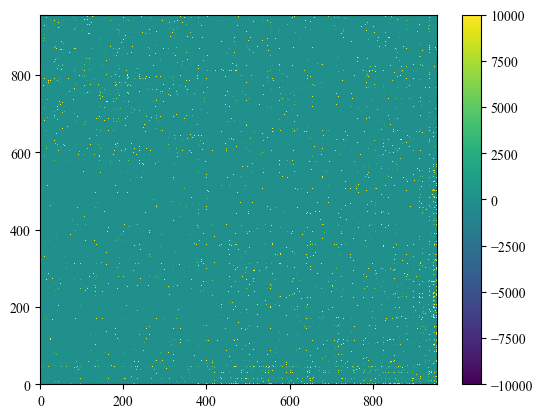

In [195]:
zoom_centre = int(connectivity_matrix.shape[0]/2) # centre to zoom on in the plot
zoom_extent = 1 # magnification
cutoff_range = 10000 # maximum extent to vary colours on the plot, for visibility
boxlims = [max(0, int(zoom_centre - connectivity_matrix.shape[0]/(2*zoom_extent))),max(0, int(zoom_centre + connectivity_matrix.shape[0]/(2*zoom_extent))),max(0, int(zoom_centre - connectivity_matrix.shape[1]/(2*zoom_extent))),max(0, int(zoom_centre + connectivity_matrix.shape[1]/(2*zoom_extent)))]

plt.imshow(connectivity_matrix, aspect="auto", vmax=cutoff_range, vmin=-cutoff_range, extent=boxlims, interpolation="none")
plt.colorbar()

### 3D position

In [196]:
nuclei_df = client.materialize.query_table('nucleus_detection_v0')
nuclei_df

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,0,0,"[381312, 273984, 19993]","[nan, nan, nan]","[nan, nan, nan]"
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,96218056992431305,864691136090135607,"[228816, 239776, 19593]","[nan, nan, nan]","[nan, nan, nan]"
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,0,0,"[340000, 279152, 20946]","[nan, nan, nan]","[nan, nan, nan]"
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,84955554103121097,864691135373893678,"[146848, 213600, 26267]","[nan, nan, nan]","[nan, nan, nan]"
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,0,0,"[339120, 276112, 19442]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...
144115,598753,2020-09-28 22:45:25.626353+00:00,NaN,t,792.030249,110506897924421202,864691135743752909,"[332576, 269216, 20733]","[nan, nan, nan]","[nan, nan, nan]"
144116,111162,2020-09-28 22:45:25.627937+00:00,NaN,t,800.065782,79244553336437996,864691134912248365,"[105344, 130400, 26721]","[nan, nan, nan]","[nan, nan, nan]"
144117,795176,2020-09-28 22:45:25.628901+00:00,NaN,t,828.325233,0,0,"[411472, 210336, 25091]","[nan, nan, nan]","[nan, nan, nan]"
144118,528334,2020-09-28 22:45:25.629787+00:00,NaN,t,896.589660,105853763977769997,864691135968943973,"[298608, 203488, 15267]","[nan, nan, nan]","[nan, nan, nan]"


In [209]:
# Positions of all cells

all_cells_pos = np.array(list(nuclei_df["pt_position"]))

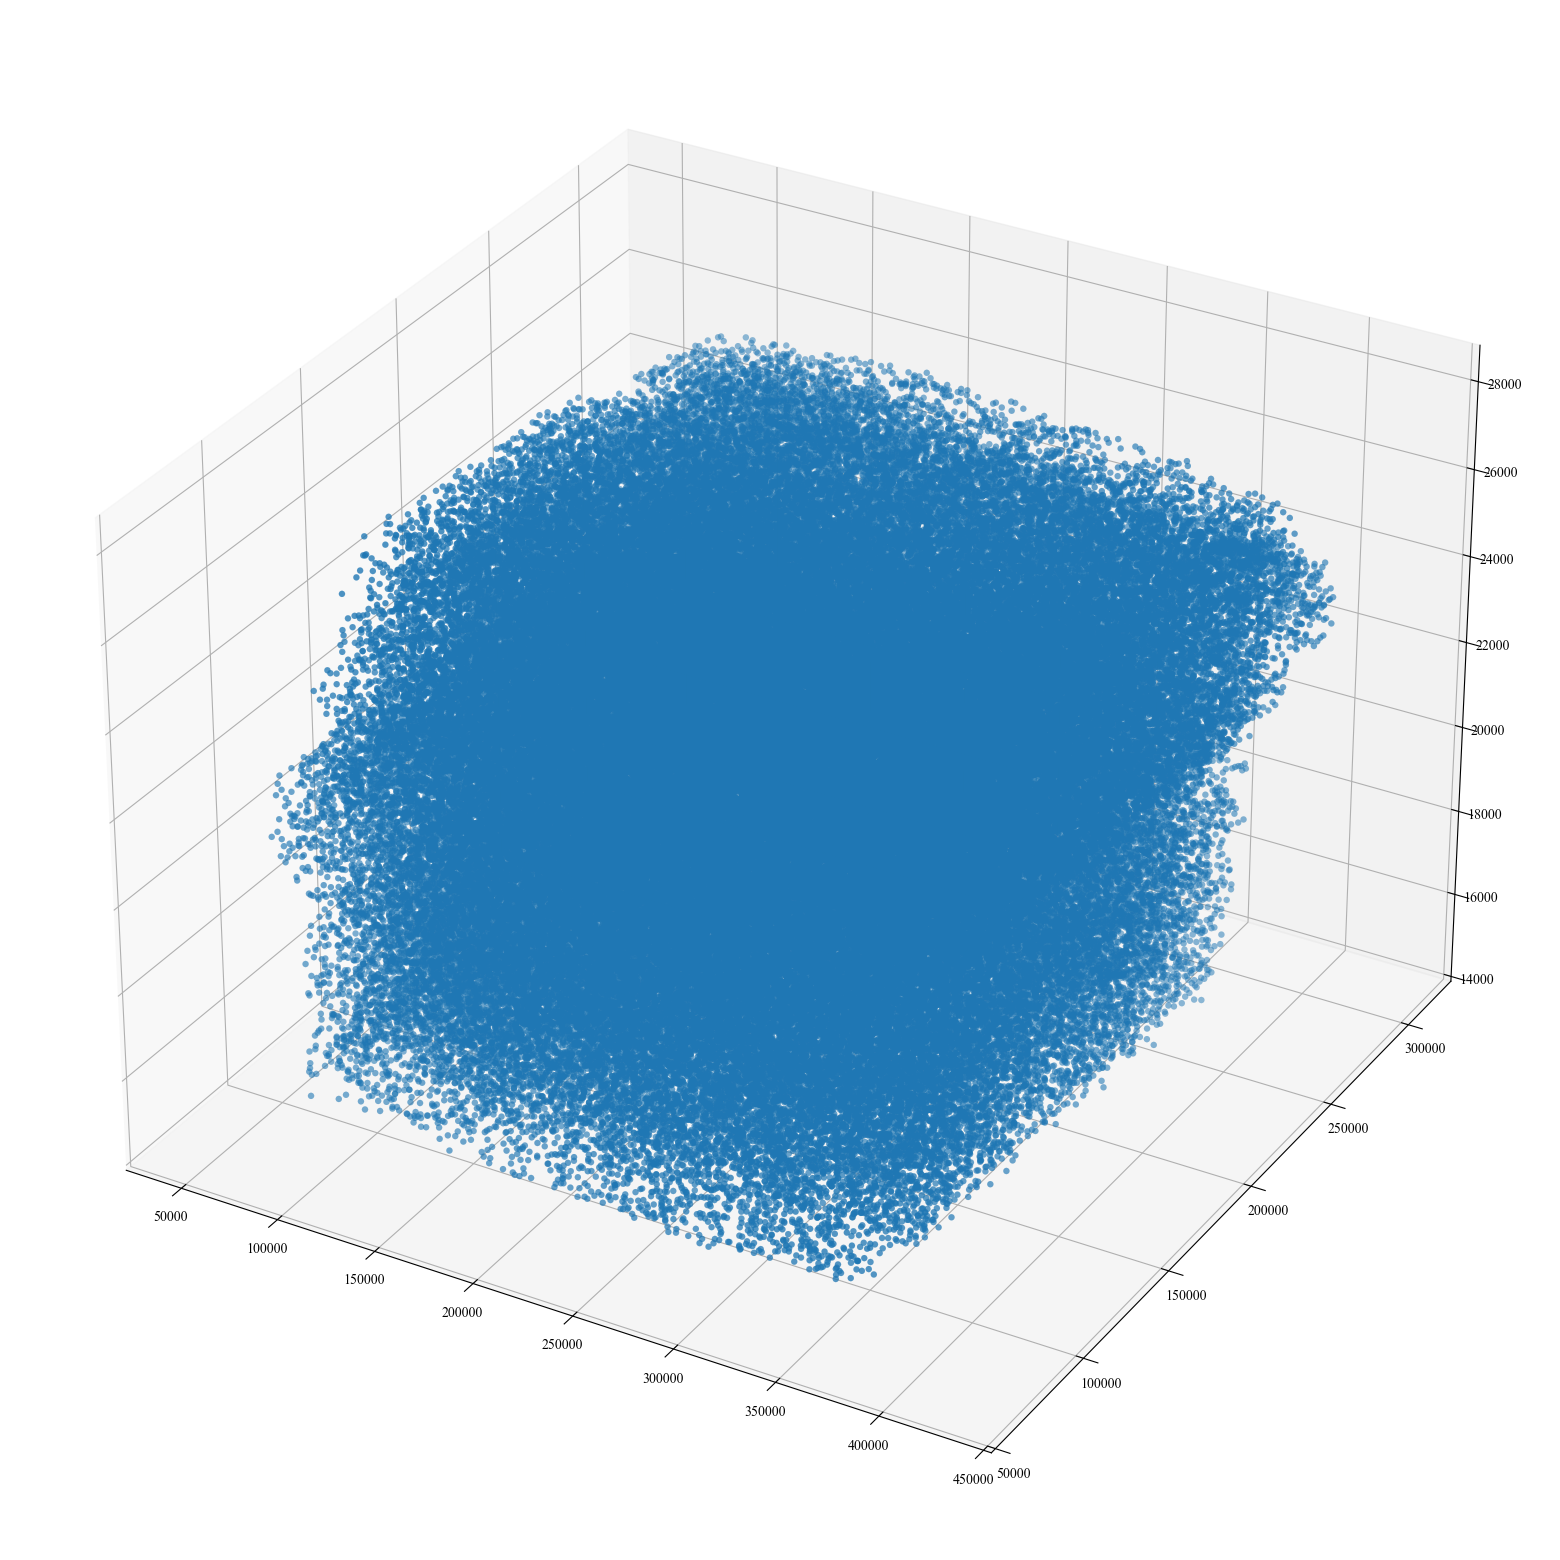

In [219]:
xs, ys, zs = all_cells_pos.T # make arrays of x, y and z coordinates

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, linewidth=0.1)

In [222]:
# Nuclei of proofread cells

proof_boolean_df = client.materialize.query_table("nucleus_detection_v0", filter_in_dict={"pt_root_id" : proofread_boolean_ids})
proof_boolean_df

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,190151,2020-09-28 22:40:41.832685+00:00,NaN,t,244.422738,84594226020662864,864691135275621605,"[144208, 142960, 17999]","[nan, nan, nan]","[nan, nan, nan]"
1,223016,2020-09-28 22:40:42.016837+00:00,NaN,t,340.046971,87264047082470146,864691135763941174,"[163680, 111392, 23197]","[nan, nan, nan]","[nan, nan, nan]"
2,222257,2020-09-28 22:40:42.018555+00:00,NaN,t,289.217249,85083714786650439,864691136488446226,"[147920, 119584, 17797]","[nan, nan, nan]","[nan, nan, nan]"
3,258319,2020-09-28 22:40:42.476911+00:00,NaN,t,261.806162,89309001002848425,864691136021936376,"[178400, 143248, 21238]","[nan, nan, nan]","[nan, nan, nan]"
4,260552,2020-09-28 22:40:42.745779+00:00,NaN,t,230.111805,89170256379033022,864691135784109363,"[177408, 157968, 21002]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...
1706,560109,2020-09-28 22:45:25.552407+00:00,NaN,t,581.823529,108806365283172458,864691135782544435,"[320048, 182208, 16927]","[nan, nan, nan]","[nan, nan, nan]"
1707,337966,2020-09-28 22:45:25.569817+00:00,NaN,t,598.549955,92763941616807901,864691136578814228,"[203520, 194512, 22991]","[nan, nan, nan]","[nan, nan, nan]"
1708,589294,2020-09-28 22:45:25.575198+00:00,NaN,t,600.946115,110706459687342783,864691136974876956,"[333888, 183296, 23598]","[nan, nan, nan]","[nan, nan, nan]"
1709,302955,2020-09-28 22:45:25.587619+00:00,NaN,t,612.866294,89949329020077684,864691135503435613,"[182864, 195440, 20817]","[nan, nan, nan]","[nan, nan, nan]"


In [223]:
# Positions of proofread cells

proofread_cells_pos = np.array(list(proof_boolean_df["pt_position"]))

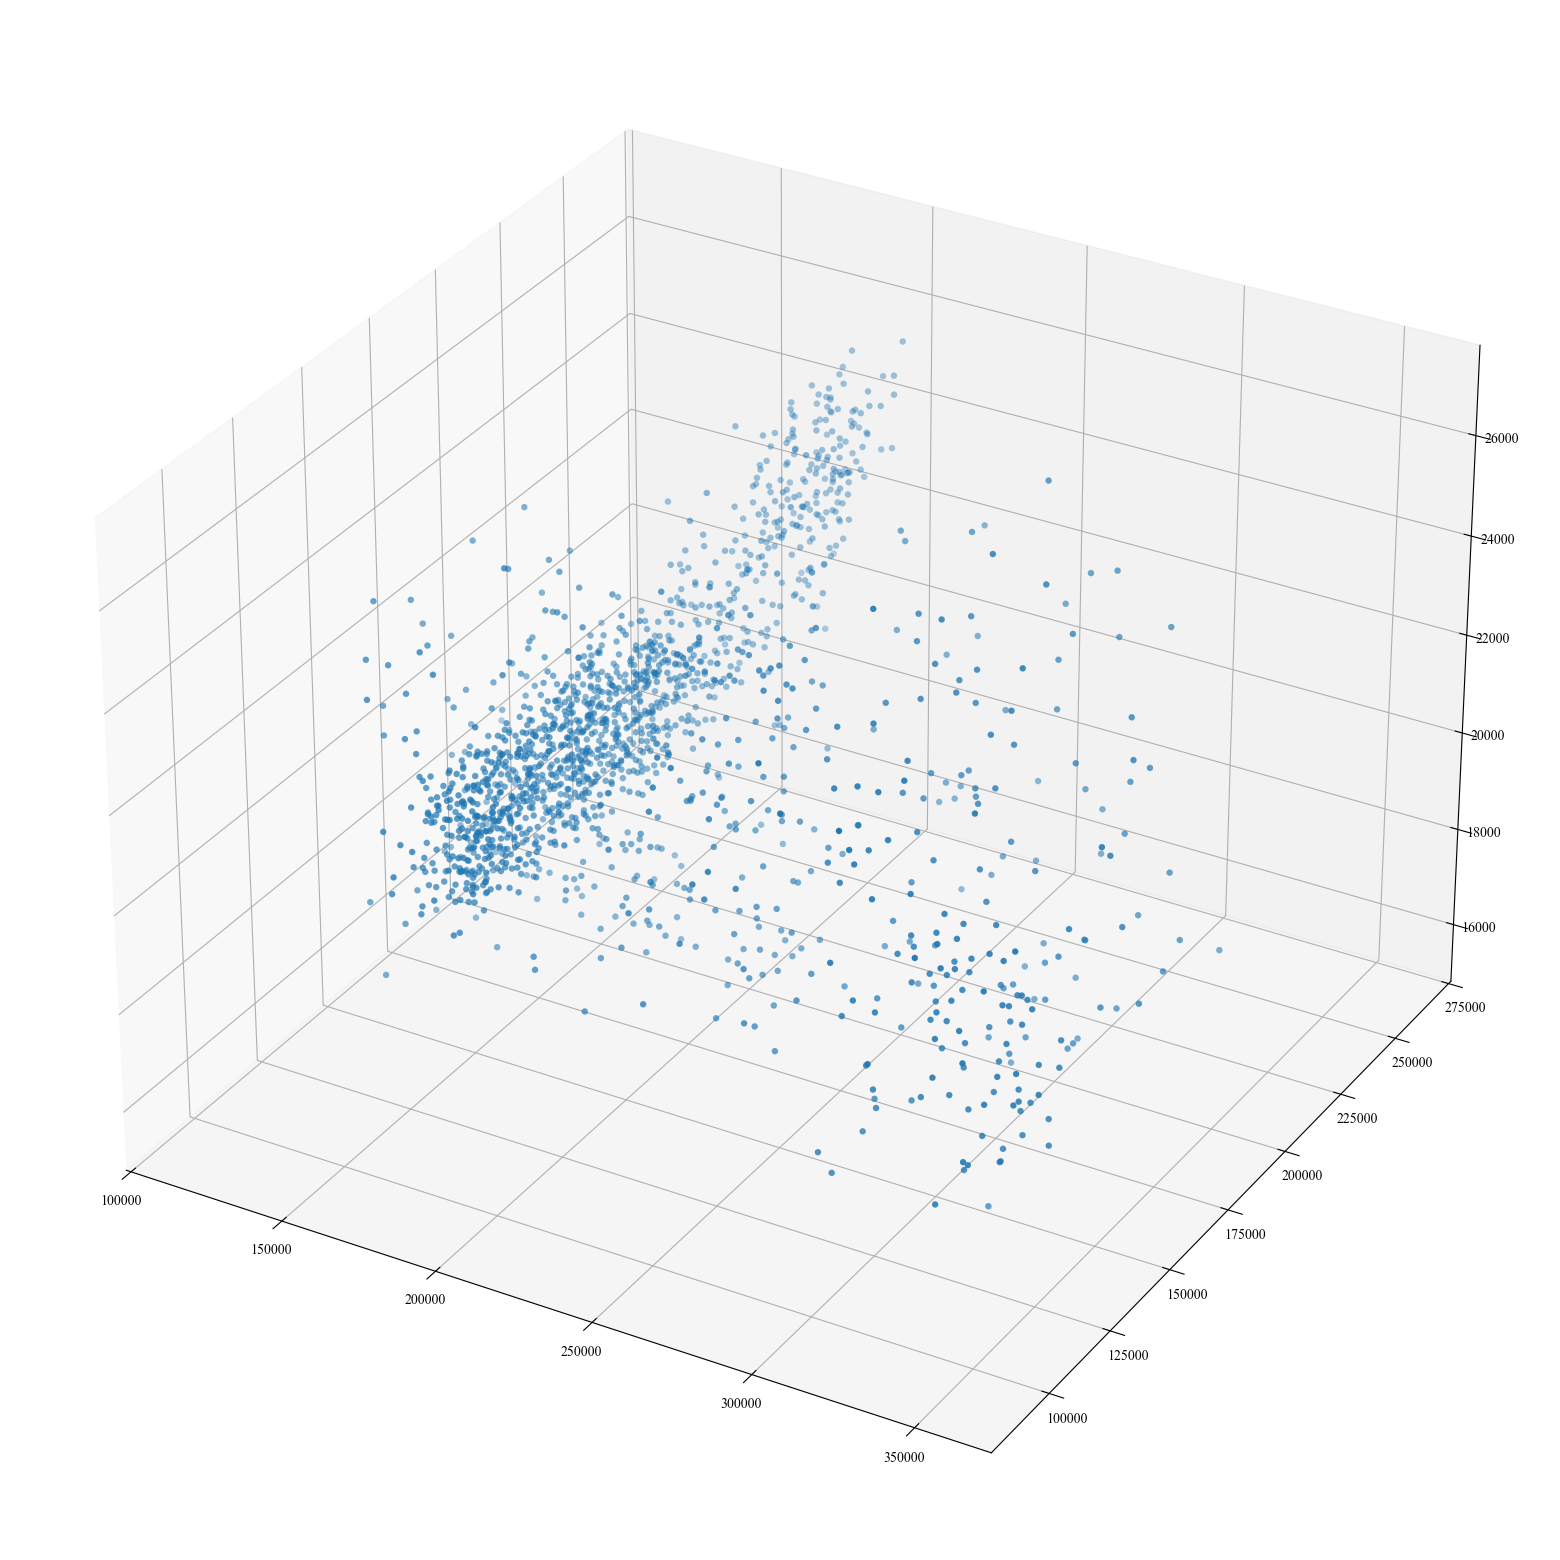

In [224]:
proof_xs, proof_ys, proof_zs = proofread_cells_pos.T # make arrays of x, y and z coordinates

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proof_xs, proof_ys, proof_zs, linewidth=0.1)